In [1]:
#This notebook was originally copied from https://www.kaggle.com/samiaimad/ai-uni-project. 
#This copy is to make changes of my own 
#using virtual environment VoiceRec1
#Rogier Landman 2022

import pandas as pd
import numpy as np
import os
import sys
import glob
import re
import splitfolders
import random
from vad import VoiceActivityDetector

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import soundfile as sf
import skimage

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

from PIL import Image


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **Assigning Data Paths to Variables**

In [2]:
Ravdess = "/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Ravdess_audio/audio_speech_actors_01-24"
CremaD = "/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Crema-D_dataset/AudioWAV"
Tess = "/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data"
Savee = "/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Savee_dataset/AudioData"


# **Audio Classification from the ravdess-emotional-speech-audio data set**

In [3]:
ravdess=glob.glob(Ravdess + "/*/*.wav")

emotion=[]
path=[]
gender=[]
intensity=[]
for i in ravdess:
    #print(i)
    isplit= i.split('.')[0]
    isplit=isplit.split('-')
    emotion.append(int(isplit[2]))
    gend=int(isplit[6])
    if gend%2==0:
        gender.append('Female')
    else:
        gender.append('Male')
    intensity.append(int(isplit[3]))
    for sp in emotion:
        if sp=="1":
            intensity.append('Normal')
    path.append(i)
edf=pd.DataFrame(emotion, columns=['Emotions'])
pdf=pd.DataFrame(path, columns=['Path'])
gdf=pd.DataFrame(gender, columns=['Gender'])
idf=pd.DataFrame(intensity, columns=['Intensity'])

ravdess_df=pd.concat([edf, pdf, gdf, idf], axis=1)

ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.Intensity.replace({1:'Normal', 2:'Strong'}, inplace=True)
ravdess_df.head()
ravdess_df.isnull()
ravdess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Emotions   1440 non-null   object
 1   Path       1440 non-null   object
 2   Gender     1440 non-null   object
 3   Intensity  1440 non-null   object
dtypes: object(4)
memory usage: 45.1+ KB


# **Audio Classification from the cremad data set**

In [4]:
crema=glob.glob(CremaD + "/*.wav")

emotion=[]
path=[]
gender=[]
intensity=[]
for f in crema:
    part2= Path(f).stem
    part2=part2.split('_')
    #print(part2)
    if int(part2[0])%2==0:
        gender.append('Female')
    else:
        gender.append('Male')
        
    if part2[2] == 'SAD':
        emotion.append('sad')
    elif part2[2] == 'ANG':
        emotion.append('angry')
    elif part2[2] == 'DIS':
        emotion.append('disgust')
    elif part2[2] == 'FEA':
        emotion.append('fear')
    elif part2[2] == 'HAP':
        emotion.append('happy')
    elif part2[2] == 'NEU':
        emotion.append('neutral')
    else:
        emotion.append('Unknown')
        
    if part2[3]=='HI':
        intensity.append('High')
    elif part2[3]=='LO':
        intensity.append('Low')
    elif part2[3]=='MD':
        intensity.append('Medium')
    elif part2[3]=='XX':
        intensity.append('Unspecified')
        
    path.append(f)
    
edf=pd.DataFrame(emotion, columns=['Emotions'])
pdf=pd.DataFrame(path, columns=['Path'])
gdf=pd.DataFrame(gender, columns=['Gender'])
idf=pd.DataFrame(intensity, columns=['Intensity'])

crema_df=pd.concat([edf, pdf, gdf, idf], axis=1)
crema_df.head()
crema_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7442 entries, 0 to 7441
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Emotions   7442 non-null   object
 1   Path       7442 non-null   object
 2   Gender     7442 non-null   object
 3   Intensity  7441 non-null   object
dtypes: object(4)
memory usage: 232.7+ KB


# **Audio Classification from the toronto-emotional-speech-set-tess data set**

In [5]:
tess=glob.glob(Tess + "/*/*.wav")

emotion=[]
path=[]
gender=[]
intensity=[]

for i in tess:
    part2= Path(i).stem
    fsplit=part2.split('_')[2]
    if fsplit=='ps':
        emotion.append('surprise')
    else:
        emotion.append(fsplit)
    gender.append('Female')
    path.append(i)
    intensity.append('Unspecified')
        
edf=pd.DataFrame(emotion, columns=['Emotions'])
pdf=pd.DataFrame(path, columns=['Path'])
gdf=pd.DataFrame(gender, columns=['Gender'])
idf=pd.DataFrame(intensity, columns=['Intensity'])

tess_df=pd.concat([edf, pdf, gdf, idf], axis=1)
tess_df.head()
tess_df.isnull()
tess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Emotions   2800 non-null   object
 1   Path       2800 non-null   object
 2   Gender     2800 non-null   object
 3   Intensity  2800 non-null   object
dtypes: object(4)
memory usage: 87.6+ KB


# **Audio Classification from Savee Dataset**

In [6]:
savee=glob.glob(Savee + "/*/*.wav")

emotion=[]
path=[]
gender=[]
intensity=[]

for f in savee:
    #dsplit = d.split(".")[0]
    #llsplit=re.split('\d+',dsplit[0])
    #print(llsplit)
    part2= Path(f).stem
    elist=part2[0]
    if elist=='a':
        emotion.append('angry')
    elif elist=='d':
        emotion.append('disgust')
    elif elist=='f':
        emotion.append('fear')
    elif elist=='h':
        emotion.append('happy')
    elif elist=='n':
        emotion.append('neutral')
    elif elist=='sa':
        emotion.append('sad')
    else:
        emotion.append('surprise')
    gender.append('Male')
    path.append(f)
    intensity.append('Unspecified')

edf=pd.DataFrame(emotion, columns=['Emotions'])
pdf=pd.DataFrame(path, columns=['Path'])
gdf=pd.DataFrame(gender, columns=['Gender'])
idf=pd.DataFrame(intensity, columns=['Intensity'])

savee_df=pd.concat([edf, pdf, gdf, idf], axis=1)
#savee_df.head()
savee_df.isnull()
savee_df.info()
savee_df.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Emotions   480 non-null    object
 1   Path       480 non-null    object
 2   Gender     480 non-null    object
 3   Intensity  480 non-null    object
dtypes: object(4)
memory usage: 15.1+ KB


,Emotions,Path,Gender,Intensity
475,surprise,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified
476,happy,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified
477,fear,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified
478,fear,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified
479,neutral,/Users/rogierlandman/from_Samsung/Machine_lear...,Male,Unspecified


# **Combining DataFrames (ravdess_df, crema_df,tess_df, savee_df)**

In [7]:
Data_Combined = pd.concat([ravdess_df, crema_df,tess_df, savee_df], axis = 0, ignore_index = True)
Data_Combined.isnull()
Data_Combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12162 entries, 0 to 12161
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Emotions   12162 non-null  object
 1   Path       12162 non-null  object
 2   Gender     12162 non-null  object
 3   Intensity  12161 non-null  object
dtypes: object(4)
memory usage: 380.2+ KB


# **Data Visualization**

In [ ]:
x = []
flag = 0

while (flag != 2000): 
   
    audio = wave.open(Data_Combined.iloc[flag, 1], 'r')
    flag = flag + 1 
    y= Data_Combined.iloc[flag, 0]
    if (len(x)>10):
        flag=2000    

    if (y not in x):
        signal = np.frombuffer(audio.readframes(-1), dtype=np.int16)
        plt.figure(figsize=(12,12))
        plot1 = plt.subplot(211)
        plot1.set_title(Data_Combined.iloc[flag, 0])
        plot1.plot(signal)
        plot1.set_xlabel('time * Number of samples')
        plot1.set_ylabel('energy')

        plot2 = plt.subplot(212)
        plot2.specgram(signal, NFFT=1024, Fs=12281, noverlap=900)
        plot2.set_xlabel('Time')
        plot2.set_ylabel('Frequency')
        
        x.append(y)

plt.show()

# **Data Augmentation**

In [ ]:
def stretch(data, rate):
    return librosa.effects.time_stretch(data, rate)
#x , sr = librosa.load(stretch(audio_data))
#ya = stretch(x)
#plt.figure(figsize=(14,4))
#librosa.display.waveplot(y=ya, sr=sr)
#Audio(ya, rate=sr)

#SNR = 20*log(RMS_s/RMS_n)


In [ ]:
def white_noise(data,SNR):
    RMS_s=math.sqrt(np.mean(data**2))
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, data.shape[0])
    data_noise=noise+data
    return data_noise 
    
#x , sr = librosa.load(audio_data)
#ya = white_noise(x,SNR=10)
#plt.figure(figsize=(14,4))
#librosa.display.waveplot(y=ya, sr=sr)
#Audio(ya, rate=sr)

In [ ]:
def shifting_time(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

#x , sr = librosa.load(audio_data)
#ya = shifting_time(x,sr,shift_max=1.5,shift_direction='right')
#plt.figure(figsize=(14,4))
#librosa.display.waveplot(y=ya, sr=sr)
#Audio(ya, rate=sr)

In [ ]:
def pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
#x , sr = librosa.load(audio_data)
#ya = pitch(x,sr,pitch_factor=0.5)
#plt.figure(figsize=(14,4))
#librosa.display.waveplot(y=ya, sr=sr)
#Audio(ya, rate=sr)

## Creating Spectograms images from Audio files (old)

In [ ]:
# to do: 
# - make spectrograms equal size
# - save only the data not the axes labels, ticks

bad_ones = []

output_path="/Users/rogierlandman/from_Samsung/Machine_learning_datasets/temp/"
if  not os.path.exists(os.path.join(output_path, 'audio-spectrograms')):
    os.mkdir(os.path.join(output_path, 'audio-spectrograms'))
    
#function to get sound and frame rate info
def get_audio_info(audio_path):
    wav = wave.open(audio_path, 'r')
    frames = wav.readframes(-1)
    audio_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return audio_info, frame_rate

for f in range (len(Data_Combined)):
        file_Path = f'{Data_Combined.iloc[f, 1]}'
        #print (file_path)
        file_stem = Path(file_Path).stem
        #print (file_stem)
        target_dir = f'class_{Data_Combined.iloc[f, 0]}'
        #print (target_dir)
        dist_dir = os.path.join(os.path.join(output_path, 'audio-spectrograms'), target_dir)
        #print (dist_dir)
        # ex: ./audio-spectrograms/class_fear
        file_dist_path = os.path.join(dist_dir, file_stem)
        #ex: ./audio-spectrograms/class_fear/03-01-06-02-02-01-10
        
    
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_Path).stem
            try:
                audio_info, frame_rate = get_audio_info(file_Path)
                pylab.specgram(audio_info, Fs=frame_rate)
                pylab.savefig(f'{file_dist_path}.png')
                pylab.close()
                print(file_Path)
            except:
                bad_ones.append(file_Path)
                print('BAD: ' + file_Path)

## Creating Spectograms images from Audio files (new)

In [ ]:
# to do: 
# - make spectrograms equal size
# - save only the data not the axes labels, ticks

bad_ones = []

output_path="/Users/rogierlandman/from_Samsung/Machine_learning_datasets/temp1/"
if  not os.path.exists(os.path.join(output_path, 'audio-spectrograms')):
    os.mkdir(os.path.join(output_path, 'audio-spectrograms'))
    
#function to get sound and frame rate info
def get_audio_info(audio_path):
    wav = wave.open(audio_path, 'r')
    frames = wav.readframes(-1)
    audio_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return audio_info, frame_rate

duration = []
for f in range (len(Data_Combined)):

        file_Path = f'{Data_Combined.iloc[f, 1]}'
        #print (file_path)
        file_stem = Path(file_Path).stem
        #print (file_stem)
        target_dir = f'class_{Data_Combined.iloc[f, 0]}'
        #print (target_dir)
        dist_dir = os.path.join(os.path.join(output_path, 'audio-spectrograms'), target_dir)
        #print (dist_dir)
        # ex: ./audio-spectrograms/class_fear
        file_dist_path = os.path.join(dist_dir, file_stem)
        #ex: ./audio-spectrograms/class_fear/03-01-06-02-02-01-10
        
    
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_Path).stem
            try:
                #new:
                #load audio ..
                data, samplerate = sf.read(file_Path)
                duration.append(len(data) * samplerate)
                
                #old:
                #audio_info, frame_rate = get_audio_info(file_Path)
                #pylab.specgram(audio_info, Fs=frame_rate)
                #pylab.savefig(f'{file_dist_path}.png')
                #pylab.close()
                print(duration)
            except:
                bad_ones.append(file_Path)
                print('BAD: ' + file_Path)

## Checking duration of audio samples

In [ ]:
output_path="/Users/rogierlandman/from_Samsung/Machine_learning_datasets/temp1/"
    
duration = []

for f in range (len(Data_Combined)):
    
    file_Path = f'{Data_Combined.iloc[f, 1]}'

    #load audio ..
    data, samplerate = sf.read(file_Path)

    #resample
    duration.append(len(data) / samplerate)

plt.hist(duration)




It turns out that there is quite a bit of variation in the length of audio samples and there are considerable periods of no signal (quiet) in the audio. 

It makes sense to try a different approach, which is to put all samples of one category together, remove quiet parts, and then re-segment into pieces of a single length

## New approach

In [ ]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(out, img)


output_path="/Users/rogierlandman/from_Samsung/Machine_learning_datasets/temp1/"

target_samplerate = 22050
hop_length = 512 # number of samples per time-step in spectrogram
n_mels = 128 # number of bins in spectrogram. Height of image
#desired segment length in seconds
segment_length = 1
segment_length_samp = np.round(segment_length * target_samplerate)  

labels = ['neutral','angry','disgust','fear','happy','sad','surprise']
labels = ['angry','disgust','fear','happy','sad','surprise']
   
for label in labels:
    
    print(label, ' accumulate data')
    lst = []
    cumdata = np.array(lst)
    for f in range (len(Data_Combined)):
    #    for f in range (3):

        #print(str(f), 'of ', str(len(Data_Combined)))
        file_Path = f'{Data_Combined.iloc[f, 1]}'
        #file_stem = Path(file_Path).stem
        #print(Data_Combined.iloc[f, 0])
        tmp = Data_Combined.iloc[f, 0]
        if(tmp == label):  
            
            try:

                v = VoiceActivityDetector(file_Path)
                tmp = v.detect_speech()

                z = tmp.shape[0]

                new_data = np.array(lst)

                for i in range(0, z-1):
                    if(tmp[i,1] == 1):

                        a=int(tmp[i+1,0])
                        b=int(tmp[i,0])
                        data=v.data[b:a]                 
                        new_data = np.concatenate([new_data,data])

                if(new_data.size>1):        
                    new_data=new_data.astype(float)
                    new_data = librosa.resample(new_data, orig_sr=v.rate, target_sr=target_samplerate)
                    c_mx = np.max(new_data) 
                    c_mn = np.min(new_data)
                    new_data = 2 * ((new_data - c_mx) / (c_mx - c_mn)) + 1 

                cumdata = np.concatenate([cumdata,new_data])
                
            except:
                
                print('Bad: ', file_Path )

                
    print(label, ' spectrograms')
    
    #chop into pieces
    n_pieces = 0
    labelstring = 'class_' + label
    if  not os.path.exists(os.path.join(output_path,  'audio-spectrograms', labelstring)):
        os.mkdir(os.path.join(output_path, 'audio-spectrograms', labelstring))

    while(len(cumdata)>segment_length_samp):
        n_pieces += 1
        tmp = cumdata[:segment_length_samp]

        #make spectrogram ..
        s1 = str(n_pieces).zfill(4)
        s2 = 'sample_' + s1 + '.png'
        
        target_path = os.path.join(output_path, 'audio-spectrograms',labelstring, s2)
        spectrogram_image(tmp, target_samplerate, target_path, hop_length, n_mels)

        #remove from big array ..
        cumdata = np.delete(cumdata, np.s_[:segment_length_samp])
    
    

angry  accumulate data
Bad:  /Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_germ_angry.wav
angry  spectrograms
disgust  accumulate data
disgust  spectrograms


In [13]:
print(file_Path)

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_germ_angry.wav


In [ ]:
v = VoiceActivityDetector(file_Path)
str(v.rate).zfill(10)

6876.010319194101
-5593.541943021665


72.22081632653061

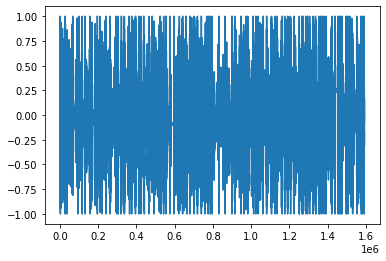

In [80]:
print(c_mx)
print(c_mn)
#data= np.arange(12).reshape((3, 4))
#print(data.ndim)
plt.plot(cumdata)
len(cumdata)/22050

In [ ]:
#replicate directory structure ..
inputpath = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/temp/audio-spectrograms/'
outputpath = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/augment/spectrograms/'

for dirpath, dirnames, filenames in os.walk(inputpath):
    for file in filenames:
        tmp = os.path.join(dirpath,file)
        p=Path(tmp)
        print(p.parts[-2])


In [ ]:
#this would be done if you augment spectrograms 
#using frequency mask and time mask
#https://towardsdatascience.com/audio-deep-learning-made-simple-part-3-data-preparation-and-augmentation-24c6e1f6b52

def freq_mask(data, F):
        
        v = data.shape[1] # no. of bins       
        # apply F frequency masks to the spectrogram
        for i in range(F):
            f = int(np.random.uniform(0, F)) # [0, F)
            f0 = random.randint(0, v - f) # [0, v - f)
            data[:, f0:f0 + f, :, :] = 0          
        return data
    
    
def time_mask(data, T):

    tau = data.shape[2] # time points
    # apply T time masks to the spectrogram
    for i in range(T):
        t = int(np.random.uniform(0, T)) # [0, T)
        t0 = random.randint(0, tau - t) # [0, tau - t)
        data[:, :, t0:t0 + t, :] = 0
    return data
    

#replicate directory structure ..
inputpath = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/temp/audio-spectrograms/'
outputpath = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/augment/spectrograms/'

for dirpath, dirnames, filenames in os.walk(inputpath):
    structure = os.path.join(outputpath, dirpath[len(inputpath):])
    if not os.path.isdir(structure):
        os.mkdir(structure)
    else:
        print("Folder already exists!")

        
#loop through spectrogram files and augment .. 
for root, directories, file in os.walk(inputpath):
    for file in file:
        if(file.endswith(".png")):
            #load the file
            img = Image.open(file)
            
            #choose frequency or time mask
            z = random.randint(0,1)
            #apply
            if(z):
                img = freq_mask(data, 10)
            else:
                img = time_mask(data, 10)
            
            #save new image
            file_stem = Path(file).stem
            new_name = file_stem + '_aug1.png'
            
            tmp = os.path.join(root,file)
            p=Path(tmp)
            class_dir = p.parts[-2]
            new_path = os.path.join(outputpath, class_dir, new_name)
            
            #to do: save as png image
            

In [ ]:
#this would be done if you augment audio but then you need time to calculate spectrograms as well

#loop through wav files and augment .. 
dest_dir = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/augment/audio/'

for f in range (len(Data_Combined)):
 
    file_Path = f'{Data_Combined.iloc[f, 1]}'
    print(file_Path)
    x, sr = librosa.load(file_Path)
    file_stem = Path(file_Path).stem

    #pick value for pitch shift
    pick = random.uniform(-1,1)
    x = pitch(x,sr, pitch_factor = pick)

    #pick value for time shift
    pick = random.uniform(0,0.5)
    x = shifting_time(x,sr,shift_max=pick,shift_direction='both')

    #pick value for time shift
    pick = random.uniform(0,5)
    x = white_noise(x,SNR=pick)

    #pick value for time stretch
    pick = random.uniform(0,0.8)
    x = stretch(x, pick)

    target_dir = f'class_{Data_Combined.iloc[f, 0]}'
    dest_dir1 = os.path.join(dest_dir, target_dir)
    dest_path = os.path.join(dest_dir1, file_stem + '_aug1.wav')

    if not os.path.exists(dest_dir1):
        os.mkdir(dest_dir1)


    sf.write(dest_path, ya, sr, 'PCM_16')
   

# **Data Preparation**

In [ ]:
# Declare constants
image_h = 256
image_w = 256
batch_size = 32
num_channel = 3
num_classes = 10
INPUT_DIR = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/temp/audio-spectrograms/'
OUTPUT_DIR = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/temp/output/'

splitfolders.ratio(INPUT_DIR, output=OUTPUT_DIR,
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [ ]:


# dataset training spectrograms
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=batch_size,
                                             validation_split=None,
                                             directory=os.path.join(OUTPUT_DIR, 'train'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(image_h, image_w),
                                             subset=None,
                                             seed=0)

# dataset validation spectrograms
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=batch_size,
                                             validation_split=None,
                                             directory=os.path.join(OUTPUT_DIR, 'val'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(image_h, image_w),
                                             subset=None,
                                             seed=0)

# dataset test spectrograms
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=batch_size,
                                             validation_split=None,
                                             directory=os.path.join(OUTPUT_DIR, 'test'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(image_h, image_w),
                                             subset=None,
                                             seed=0)

# dataset validation spectrogram
#validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#                                             batch_size=batch_size,
#                                             validation_split=0.2,
#                                             directory=os.path.join(OUTPUT_DIR, 'audio-spectrograms'),
#                                             shuffle=True,
#                                             color_mode='rgb',
#                                             image_size=(image_h, image_w),
#                                             subset="validation",
#                                             seed=0)

In [ ]:
def prepare(ds):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    return ds

training_dataset = prepare(training_dataset)
validation_dataset = prepare(validation_dataset)
test_dataset = prepare(test_dataset)

# **Modeling**

In [ ]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(image_h,image_w,num_channel)))
#convolution layer
model.add(tf.keras.layers.Conv2D(32,3,strides=2,padding='same',activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
#pooling layer
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
#fully connected layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
#output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(),metrics=['accuracy'],)

history=model.fit(training_dataset, epochs=3, validation_data=validation_dataset)

In [ ]:
#loss graph for training and validation
history1=history.history
loss=history1['loss']
values=history1['val_loss']
epochs=range(1,len(loss)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
final_loss, final_acc=model.evaluate(test_dataset, verbose=0)
print("Final loss: {0:.6f}\n Final accuracy: {1:.6f}".format(final_loss, final_acc))